In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numba

### Pyplot parameters for plotting
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',  # Use a serif font
    'font.size': 10,         # Adjust the font size to match your LaTeX document
})

# For a two-column document, set the figure width to be within the column width
column_width_pt = 246  # Adjust this based on your document's column width
inches_per_pt = 1/72.27
golden_ratio = (5**0.5 - 1) / 2  # Golden ratio to make the figure aesthetically pleasing

fig_width = column_width_pt * inches_per_pt
fig_height = fig_width * golden_ratio



plt.style.use('default')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "lines.linewidth" : 1.2,
          'xtick.minor.width' : 0.75,
          'xtick.major.width' : 0.75,
          'ytick.minor.width' : 0.75,
          'ytick.major.width' : 0.75,
          'axes.spines.top' : True,
          'axes.spines.right' : True,
          'axes.linewidth' : 1.5}
plt.rcParams.update(params)
plt.rc('figure', figsize=(fig_width, fig_height))
plt.rc('legend', frameon=False)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

def blocking_cv(x,temperatura, n = 1000):
    x = np.array(x)
    n0 = int(len(x)/n)
    cvs = np.zeros(n0)
    for idx in range(n0):
        e0 = x[idx*n:(idx+1)*n]
        e0sq = np.power(e0,2)
        cvs[idx] = (np.mean(e0sq)-np.mean(e0)**2)/(temperatura*temperatura)
    return (np.mean(cvs),np.sqrt(np.mean(np.power(cvs,2))-np.mean(cvs)**2))

def bootstrap_cv(x, temperatura, n=100):
    x = np.array(x)
    cvs = np.zeros(n)
    for iteration in range(n):
        x_resampled = np.random.choice(x,len(x))
        cvs[iteration] = (np.mean(np.power(x_resampled,2))-np.mean(x_resampled)**2)/(temperatura**2)

    return (np.mean(cvs),np.sqrt(np.mean(np.power(cvs,2))-np.mean(cvs)**2))

def process_data(fileRoot,numFiles,nSpins, distances):  
    e_mean = np.zeros(numFiles)
    m_mean = np.zeros(numFiles)
    cv_mean = np.zeros(numFiles)
    cv_mean_err = np.zeros(numFiles)
    corr_mean = np.zeros((distances+1,numFiles))
    amount = 0
    temp_list = np.array([0.01, 0.131376, 0.219251, 0.289728, 0.340823, 0.379602, 0.408956, 0.434811, 0.459629, 0.486642, 0.516451, 0.549955, 0.585714, 0.623892, 0.664056, 0.706375, 0.750844, 0.79683, 0.843976, 0.892545, 0.943283, 0.996873, 1.05372, 1.1142, 1.17888, 1.24838, 1.32324, 1.40397, 1.4912, 1.5856, 1.68775, 1.79797, 1.9165, 2.04445, 2.18401, 2.33889, 2.51478, 2.71531, 2.9355, 3.17538, 3.45155, 3.77533, 4.17207, 4.62782, 5.11526, 5.69715, 6.52581, 7.80651, 9.18764, 10.0])
    headers = ['Energia','Magnetizacion','Temperatura']
    for idx in range(distances+1):
        headers.append('Corr'+str(idx))

    for idx,t in enumerate(temp_list):
        e_list = []
        m_list = []
        for idx2 in range(numFiles):
            #print("File Root : "+fileRoot+" Currently on file number "+str(idx2)," at temperature T = ",t,'     ',end = '\r')
            procesos_df = pd.read_csv(fileRoot+str(idx2)+".csv",delimiter="\t", skiprows = 1, header = None,names = headers)
            e = np.array(procesos_df[procesos_df["Temperatura"] == t]["Energia"].to_list())
            print("Unit cells: ",int(nSpins/24),"Current file idx",idx2,"Current temperature idx",idx,'       ',end ='\r')
            m = np.array(procesos_df[procesos_df["Temperatura"] == t]["Magnetizacion"].to_list())
            corrs = np.zeros(distances+1)
            e_list.append(e)
            m_list.append(m)
            for corrI in range(1,distances+1):
                corrs[corrI-1] = np.sum(np.array(procesos_df[procesos_df["Temperatura"] == t]["Corr"+str(corrI)].to_list()))
            corr_mean[:,idx] += corrs
            amount += len(e)
        e_list = np.concatenate(e_list)
        m_list = np.concatenate(m_list)
        e_mean[idx] = np.mean(e_list)
        cvs =  bootstrap_cv(e_list,t,n = 10)
        cv_mean[idx] += cvs[0]
        cv_mean_err[idx] += cvs[1]
        
        m_mean[idx] = np.mean(m_list)
        
    return (corr_mean/(amount),e_mean/(nSpins),m_mean/(nSpins),cv_mean/(nSpins),cv_mean_err/(nSpins),temp_list)

### No external field

In [26]:
corr64,e64,m64,cv64,cverr64, t64 = process_data("../PT-Data/0Field/DatosN64Proceso",50,24*64,9)
corr1, e1,m1,cv1,cverr1, t1 = process_data("../PT-Data/0Field/DatosN1Proceso",50,24,-1)
corr8, e8,m8,cv8,cverr8, t8 = process_data("../PT-Data/0Field/DatosN8Proceso",50,24*8,-1)


   Energia  Magnetizacion  Temperatura  Corr0     Corr1     Corr2     Corr3  \
0    -1692             12     0.664056      0 -0.314732  0.117808 -0.040830   
1    -1716              0     0.664056      0 -0.319196  0.125744 -0.042597   
2    -1718             -6     0.664056      0 -0.319568  0.123636 -0.041853   
3    -1728            -12     0.664056      0 -0.321429  0.124008 -0.040644   
4    -1718             -6     0.664056      0 -0.319568  0.118676 -0.036086   

      Corr4     Corr5     Corr6     Corr7     Corr8     Corr9  
0  0.013579 -0.005598  0.002002 -0.000219 -0.000194 -0.015625  
1  0.014211 -0.006041  0.001813  0.000088 -0.001035  0.000000  
2  0.015067 -0.007334  0.003411 -0.002342  0.001601 -0.031250  
3  0.012835 -0.005155  0.002085 -0.000657 -0.000129 -0.023438  
4  0.007775 -0.001063 -0.000152  0.000489 -0.000146 -0.031250  
   Energia  Magnetizacion  Temperatura  Corr0     Corr1     Corr2     Corr3  \
0    -1700             -8     0.706375      0 -0.316220  0.120

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [60]:
np.save("./corr64.npy",corr64)
np.save("./e64.npy",e64)
np.save("./m64.npy",m64)
np.save("./cv64.npy",cv64)
np.save("./cverr64.npy",cverr64)
np.save("./t64.npy",t64)

np.save("./e1.npy",e1)
np.save("./m1.npy",m1)
np.save("./cv1.npy",cv1)
np.save("./cverr1.npy",cverr1)
np.save("./t1.npy",t1)

np.save("./e8.npy",e8)
np.save("./m8.npy",m8)
np.save("./cv8.npy",cv8)
np.save("./cverr8.npy",cverr8)
np.save("./t8.npy",t8)


[3.77772730e-02 2.25981069e-04 4.13674011e-03 2.09519935e-02
 4.26579542e-02 6.20400852e-02 7.90452521e-02 9.38118461e-02
 1.08302168e-01 1.24027394e-01 1.40050307e-01 1.56560418e-01
 1.72762019e-01 1.87716756e-01 2.00431561e-01 2.12012065e-01
 2.20005068e-01 2.26786430e-01 2.31375018e-01 2.34426948e-01
 2.35776791e-01 2.35946648e-01 2.34829619e-01 2.32886658e-01
 2.30766095e-01 2.27229087e-01 2.22625995e-01 2.17701168e-01
 2.12639840e-01 2.06468299e-01 1.99587325e-01 1.92995021e-01
 1.85580275e-01 1.77543001e-01 1.69167345e-01 1.60348765e-01
 1.50637246e-01 1.40653984e-01 1.29865792e-01 1.20056260e-01
 1.09822933e-01 9.87787932e-02 8.76346525e-02 7.66372232e-02
 6.69589337e-02 5.75134974e-02 4.69895951e-02 3.59209836e-02
 2.76354900e-02 2.40942899e-02]


In [10]:
corr64 = np.load("./ProcessedData/corr64.npy")
e64 = np.load("./ProcessedData/e64.npy")
m64 = np.load("./ProcessedData/m64.npy")
cv64 = np.load("./ProcessedData/cv64.npy")
cverr64 = np.load("./ProcessedData/cverr64.npy")
t64 = np.load("./ProcessedData/t64.npy")

e1 = np.load("./ProcessedData/e1.npy")
m1 = np.load("./ProcessedData/m1.npy")
cv1 = np.load("./ProcessedData/cv1.npy")
cverr1 = np.load("./ProcessedData/cverr1.npy")
t1 = np.load("./ProcessedData/t1.npy")

# e8 = np.load("./ProcessedData/e8.npy")
# m8 = np.load("./ProcessedData/m8.npy")
# cv8 = np.load("./ProcessedData/cv8.npy")
# cverr8 = np.load("./ProcessedData/cverr8.npy")
# t8 = np.load("./ProcessedData/t8.npy")

/tmp/ipykernel_64906/2042262207.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figCv.show()
/tmp/ipykernel_64906/2042262207.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figEnergy.show()


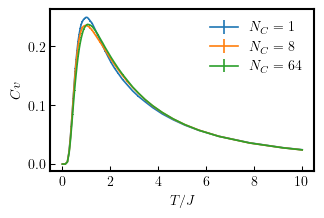

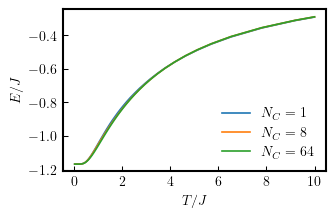

In [7]:
figCv, axCv = plt.subplots() 
axCv.errorbar(np.array(t1),cv1,2*cverr1, label = r'$N_C = 1$')
axCv.errorbar(np.array(t8),cv8,2*cverr8, label = r'$N_C = 8$')
axCv.errorbar(np.array(t64),cv64,2*cverr64, label = r'$N_C = 64$')
axCv.set_ylabel(r'$Cv$')
axCv.set_xlabel(r'$T/J$')
axCv.legend()
figCv.savefig("./CvAntiferro.eps",format = 'eps',dpi=800, bbox_inches = 'tight',pad_inches = 0.03)
figCv.show()


figEnergy, axEnergy = plt.subplots()
axEnergy.plot(np.array(t1),e1, label = r'$N_C = 1$')
axEnergy.plot(np.array(t8),e8, label = r'$N_C = 8$')
axEnergy.plot(np.array(t64),e64, label = r'$N_C = 64$')
axEnergy.set_ylabel(r'$E/J$')
axEnergy.set_xlabel(r'$T/J$')
axEnergy.legend()
figEnergy.savefig("./EnergyAntiferro.eps",format = 'eps',dpi=800, bbox_inches = 'tight',pad_inches = 0.03)
figEnergy.show()

In [43]:
corr64[-1,:] =corr64[-1,:]/(64*24) 

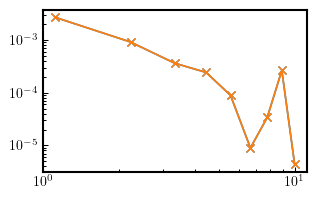

In [47]:
figCorr, axCorr = plt.subplots()
axCorr.plot(np.linspace(0,10,10)[1:],np.abs(corr64)[1:,0],'x-', label = r'$N_C = 1$')
axCorr.plot(np.linspace(0,10,10)[1:],np.abs(corr64)[1:,1],'x-', label = r'$N_C = 1$')
axCorr.set_xscale('log')
axCorr.set_yscale('log')

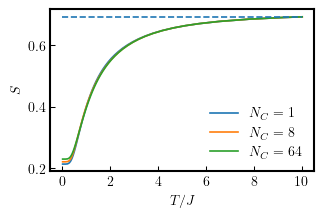

In [59]:
### Entropy calculation
from scipy.integrate import simps as simps
from scipy.integrate import trapz as trapz
def entropy(cv, temp):
    e1 = [np.log(2)-trapz(cv[n:]/temp[n:],temp[n:]) for n in range(len(cv))]
    return e1


figEntropy, axEntropy = plt.subplots()


axEntropy.plot(t1,entropy(cv1,t1), label = r'$N_C = 1$')
axEntropy.plot(t8,entropy(cv8,t8), label = r'$N_C = 8$')
axEntropy.plot(t64,entropy(cv64,t64), label = r'$N_C = 64$')
axEntropy.hlines(np.log(2),0,10,linestyles='dashed')
axEntropy.set_ylabel(r'$S$')
axEntropy.set_xlabel(r'$T/J$')
axEntropy.legend()

figEntropy.savefig("./fig_chHypModels_entropy37.eps",format = 'eps',dpi=800, bbox_inches = 'tight',pad_inches = 0.03)

## With external field

In [4]:
corr8, e8,m8,cv8,cverr8, t8 = process_data("../PT-Data/05Field/DatosN8Proceso",50,24*8,-1)

In [11]:
print(e8[0],e64[0])

-1.2280204531249999 -1.1666666666666667


### Temperature ladder

In [29]:
### Workers analysis

def process_workers(fileRoot,numFiles):
    procesos_dfs = []
    for idx in range(numFiles):
        procesos_dfs.append(pd.read_csv(fileRoot+str(idx)+".csv",delimiter="\t"))
    dfs = pd.concat(procesos_dfs, join="inner")

    temp_list = sorted(list(dfs["Temperature"].value_counts().index))
    a_timeseries = []
    m_timeseries = []
    for t in temp_list:
        a_timeseries.append(np.array(dfs[dfs["Temperature"] == t]["Accepts"].to_list()))
        m_timeseries.append(np.array(dfs[dfs["Temperature"] == t]["Total"].to_list()))
    a_mean = np.sum(np.array(a_timeseries),axis = 1)
    m_mean = np.sum(np.array(m_timeseries),axis = 1)
    plt.plot(temp_list,a_mean/m_mean)
    plt.show()
    return procesos_dfs
    

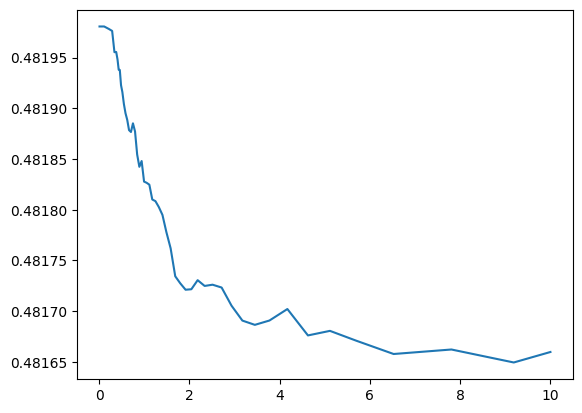

In [30]:
procesos_dfs = process_workers("../PT-Data/0Field/CountersProceso64",50)

In [31]:
m = 50
from collections import Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

f_functions = []
upts = np.zeros(len(t64))
dwns = np.zeros(len(t64))
others = np.zeros(len(t64))
for n in range(m):
    print(n,'       ', end = '\r')
    ts = np.array(procesos_dfs[n].Temperature)
    labels = np.zeros(len(ts))
    currentLabel = 0
    for idx,t in enumerate(ts):
        if t == t64[0]:
            currentLabel = 1
        elif t==t64[-1]:
            currentLabel = -1
        labels[idx] = currentLabel    
        

    for idxt,t in enumerate(t64):
        upts[idxt] += np.sum((ts == t) & (labels == 1))
        dwns[idxt] += np.sum((ts == t) & (labels == -1))
        others[idxt] += np.sum((ts == t) & (labels == 0))


[1.         0.99209081 0.98966261 0.97038192 0.9388749  0.9105641
 0.89168764 0.87568473 0.8604804  0.84445425 0.82597191 0.80627137
 0.78473628 0.76267508 0.7406892  0.71836288 0.69552633 0.67334204
 0.65172849 0.63153282 0.61315794 0.59387081 0.57314831 0.55236338
 0.53176847 0.513518   0.49433668 0.47249709 0.45170876 0.42957345
 0.40923727 0.3891536  0.36903342 0.34845728 0.32904949 0.30787144
 0.28809952 0.26663645 0.246088   0.22559553 0.20394239 0.18211987
 0.15721614 0.13436745 0.11516477 0.09693321 0.07147744 0.03619692
 0.01436263 0.        ]
[0.01, 0.1805303663, 0.2825041075, 0.33820693599999996, 0.3773954749, 0.4078229356, 0.4357813838, 0.4639970021, 0.4949050548, 0.5281774, 0.5632895311, 0.59926719, 0.6362986596, 0.6744791697, 0.7142682475, 0.7560036292, 0.7996870476, 0.8454719251999999, 0.8938185238, 0.9452443939999999, 0.9999711615, 1.058122944, 1.120124688, 1.1866223, 1.257947108, 1.334025528, 1.415022041, 1.50171616, 1.5953246799999998, 1.6970525680000002, 1.8075472240

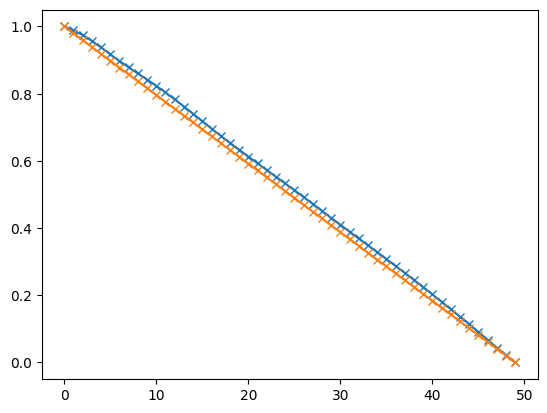

In [32]:
from scipy.stats import linregress as lr
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate



t64 = np.array(t64)
fFunc = upts/(upts+dwns)
print(fFunc)
fSmooth = fFunc
deltaTs = np.diff(t64)

for idx in range(len(fFunc)-1):
    if fFunc[idx+1] > fFunc[idx]:
        fFunc[idx+1] = fFunc[idx]

for smoothing in range(20):
    for idx in range(1,len(fFunc)-1):
        fSmooth[idx] = 0.1*fFunc[idx-1]+0.8*fFunc[idx]+0.1*fFunc[idx+1]
    fFunc = fSmooth


num_interp = 10000

t_interp = []
f_interp = []

for idxI in range(1,len(fFunc)):
    for idxJ in range(num_interp):
        t_interp.append((1.0*idxJ)/num_interp*(t64[idxI]-t64[idxI-1])+t64[idxI-1])
        f_interp.append((1.0*idxJ)/num_interp*(fFunc[idxI]-fFunc[idxI-1])+fFunc[idxI-1])

t_interp = np.array(t_interp)
f_interp = np.array(f_interp)

f_Linear = np.linspace(f_interp.max(),f_interp.min(),len(fFunc))

newTs = np.zeros(len(fFunc))
newTs[0] = t64[0]
newTs[-1] = t64[-1]
for idxI in range(1,len(fFunc)-1):
    idx = np.argmin(np.abs(f_interp-f_Linear[idxI]))
    newTs[idxI] = t_interp[idx] 

print(list(newTs))
plt.plot(fFunc,'x-')
plt.plot(f_Linear,'x-')
#plt.plot(t_interp,f_interp-f_Linear[39],)
#plt.show()

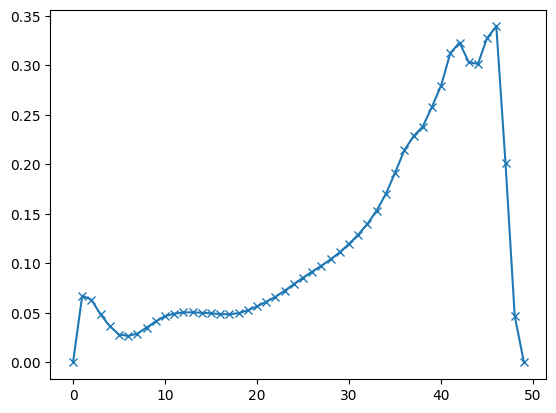

In [33]:
plt.plot(newTs-t64,'x-')
#plt.plot(t64,'x-')